# ДЗ #4. Feature engineering & advanced preprocessing <a id="0"></a>

### Использованный датасет: https://archive.ics.uci.edu/ml/datasets/IDA2016Challenge

* [Загрузка и подготовка данных](#1)
* [Базовые статистики датасета](#2)
* [Процедуры для тестирования качества модели](#3)
* [Route #1](#4)
    * Baseline 
    * Определим и удалим сильноскоррелированные признаки
    * Определим и устраним дисбаланс классов целевой переменной
    * Применим log(x+1) к данным
    * Вывод
* [Route #2](#5)
    * Baseline 
    * Определим и удалим сильноскоррелированные признаки
    * Определим и устраним дисбаланс классов целевой переменной
    * Определим 10 популярных features и сократим модель
    * Применим log(x+1) к данным
    * Вывод
* [Итоговое заключение](#6)

In [1]:
# Импорт основных библиотек
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
warnings.filterwarnings("ignore")
np.random.seed(42)

<a id="1"></a>
## Загрузка и подготовка данных [(Наверх)](#0) 

### Заметим, что: 
* все данные упакованы в архив
* архив состоит из двух датасетов (train, test)
* перед данным содержится copyright, занимающий 20 строк
* Значения NaN представлены как 'na'

In [2]:
# Напишем процедуру для получения архива и его распаковки
def get_and_unzip(file_url, output_dir=''):
    ''' Получает zip-архив с данными, распаковывает и возвращает имена файлов

        Arguments:
            file_url   {str}  - web-адрес архива
            output_dir {str}  - имя каталога для распаковки файлов (если не задано, 
                                то распаковка в текущий)

        Returns:
            Возвращает list() с именами файлов с сортировкой по убыванию размера

    '''
    from zipfile import ZipFile
    import requests
    
    output_list = []
    
    if output_dir:
        if not os.path.exists(output_dir) and not os.path.isfile(output_dir):
            os.mkdir(output_dir)
        
    req = requests.get(file_url, stream=True)
    z_temp = os.path.join(output_dir, '_zipfile.zip')

    with open(z_temp,'wb') as f:
        for chunk in req.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                
    zf = ZipFile(z_temp)
    zf_list = list(filter(lambda x: not x.is_dir(), zf.infolist()))
    zf_list.sort(key=lambda x: x.file_size, reverse=True)
    
    for f_ in zf_list:
        zf.extract(f_, path=output_dir)
        output_list.append(f_.filename)
    
    zf.close()
    os.remove(z_temp)
    
    return output_list

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00414/to_uci.zip'
filename = './data/scania.csv'
tempdir = 'temp'

if not os.path.exists(filename):
    # Скачаем и распакуем архив, получим список файлов
    sets_list = get_and_unzip(url, tempdir)
    
    # Загрузим датасеты с учетом представленного значения NaN и удалим copyright
    set1 = pd.read_csv(os.path.join(tempdir, sets_list[0]), skiprows=20, na_values='na')
    set2 = pd.read_csv(os.path.join(tempdir, sets_list[1]), skiprows=20, na_values='na')
    
    # Объединим датасеты (train, test) в один
    scania_df = pd.concat([set1, set2], sort=False)
    scania_df.to_csv(filename, index=False)

else:
    scania_df = pd.read_csv(filename)

In [4]:
# Проверим корректно ли загружен CSV
scania_df

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,neg,81852,NaN,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
75996,neg,18,0.0,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
75997,neg,79636,NaN,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
75998,neg,110,NaN,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


<a id="2"></a>
## Базовые статистики датасета [(Наверх)](#0) 

In [5]:
# Узнаем размер датасета
scania_df.shape

(76000, 171)

In [6]:
# Узнаем свойства датасета
scania_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 99.2+ MB


In [7]:
# Проверим на дубликаты и удалим если есть
scania_df.drop_duplicates(inplace=True)
scania_df.duplicated().sum()

0

In [8]:
# Проверим на наличие пустых данных
scania_df.isnull().sum()

class         0
aa_000        0
ab_000    58692
ac_000     4261
ad_000    18842
          ...  
ee_007      863
ee_008      863
ee_009      863
ef_000     3486
eg_000     3485
Length: 171, dtype: int64

In [9]:
scania_df.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,7.600000e+04,17308.000000,7.173900e+04,5.715800e+04,72810.000000,72810.000000,7.514000e+04,7.514000e+04,7.514000e+04,7.514000e+04,...,7.513700e+04,7.513700e+04,7.513700e+04,7.513700e+04,7.513700e+04,7.513700e+04,7.513700e+04,7.513700e+04,72514.000000,72515.000000
mean,6.115976e+04,0.725560,3.564398e+08,1.506300e+05,6.736959,10.836314,2.004306e+02,1.204761e+03,9.697328e+03,9.364902e+04,...,4.495763e+05,2.132460e+05,4.506478e+05,4.006204e+05,3.378689e+05,3.475611e+05,1.398968e+05,8.424984e+03,0.085197,0.219044
std,2.647366e+05,3.311913,7.952530e+08,3.590593e+07,153.446469,201.594853,1.843612e+04,5.099091e+04,1.718996e+05,8.244157e+05,...,1.177226e+06,5.518865e+05,1.189909e+06,1.151635e+06,1.097909e+06,1.707593e+06,4.692327e+05,4.875440e+04,4.179600,10.237051
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.600000e+02,0.000000,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.986000e+03,1.184000e+03,2.730000e+03,3.646000e+03,5.300000e+02,1.120000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.081300e+04,0.000000,1.540000e+02,1.280000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.354480e+05,1.126720e+05,2.230020e+05,1.909860e+05,9.353600e+04,4.126000e+04,3.862000e+03,0.000000e+00,0.000000,0.000000
75%,4.884000e+04,0.000000,9.700000e+02,4.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.386740e+05,2.184100e+05,4.676340e+05,4.032900e+05,2.761800e+05,1.680460e+05,1.395000e+05,2.000000e+03,0.000000,0.000000
max,4.294967e+07,204.000000,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,1.047252e+07,1.914916e+07,7.305747e+07,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,4.215944e+07,1.195801e+08,1.926740e+07,4.570398e+06,482.000000,1720.000000


<a id="3"></a>
## Процедуры для тестирования качества модели [(Наверх)](#0) 

In [10]:
# Импортируем библиотеки для ML
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

In [11]:
def balanced_sample(data, target_class, count=1):
    ''' Формирует сбалансированный датасет c заданным количеством значений,
        но не более минимального значения в 'target_class'
        
        Arguments:
            data          {pd.df}  - Pandas.Dataframe
            target_class  {str}    - Название целевой переменной 
            count         {int}    - количество значений

        Returns:
            Возвращает Pandas.Dataframe
        
    '''
    output_sample = pd.DataFrame()
    unique_values = data[target_class].value_counts()
    
    if count>unique_values.min(): count = unique_values.min()
        
    for i in unique_values.index:
        splitted_data = data[data[target_class]==i].sample(n=count, random_state=42)
        output_sample = pd.concat([output_sample, splitted_data])
    
    return output_sample

In [12]:
def split_train_test_sets(df, target, test_size=0.3):
    ''' Разбивает датасет на X, y сеты с заранее заданными параметрами

        Arguments:
            df      {pd.df}  - Pandas.Dataframe
            target    {str}  - Название целевой переменной 
            test_size {0.3}  - % разбивки, по-умолчанию 70:30

        Returns:
            Возвращает X|y test, train сеты

    '''
    X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=[target], axis=1),
                                                        df[target], test_size=test_size,
                                                        stratify=df[target], random_state=42)

    return X_train, X_test, y_train, y_test

In [13]:
# Процедура шкалирования переменных с выбором метода
def scale_sets(X_train, X_test, scaler_type='std'):
    if scaler_type=='std':
        scaler = StandardScaler()
    elif scaler_type=='m&m':
        scaler = MinMaxScaler()
    elif scaler_type=='rbs':
        scaler = RobustScaler()
        
    scaler.fit(X_train)
        
    return scaler.transform(X_train), scaler.transform(X_test)

In [14]:
# Процедура оценки качества
def quality_report(prediction, actual):
    output = [accuracy_score(prediction, actual),
              precision_score(prediction, actual),
              recall_score(prediction, actual),
              f1_score(prediction, actual),
              roc_auc_score(prediction, actual)]
    
    return output

In [15]:
# Процедура для выбора оптимального набора параметров, используя поиск по сетке (GridSearchCV)
def grid_cv(set_X, set_y, estimator, parameters):
    gcv = GridSearchCV(estimator=estimator, param_grid=parameters,
                       scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    gcv.fit(set_X, set_y)
    
    return dict(best_parameters=gcv.best_params_, best_score=gcv.best_score_)

In [16]:
def evaluate_data(test_df, target, report_df=None, classifier='both', scaler_type='std', 
                  cv=False, ovs=False, test_size=0.3, test_label='', get_params=False):
    ''' Проводится тестирование модели и возвращается результат о качестве

        Arguments:
            test_df      {pd.df}                - Тестируемый pd.df
            target       {string}               - Название целевой переменной
            report_df    {pd.df}                - pd.df для добавления отчета 
            classifier   {'logr'|'knn'|'both'}  - Вид модели
            scaler_type  {'std'|'m&m'|'rbs'}    - Вариант шкалирования
            cv           {True|False}           - Использовать GridCV
            ovs          {True|False}           - Использовать over_sampling
            test_size    {0.3}                  - % разбивки, по-умолчанию 70:30
            test_label   {string}               - Название теста
            get_params   {True|False}           - Вывод параметров модели в отчет

        Returns:
            Возвращает pd.df с результатами тестирования

    '''    
    # Создадим df для фиксации результатов
    if report_df is None:
        report_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'Best params'])
        for col in report_df.columns[:-1]:
            report_df[col] = report_df[col].astype('float32')
    
    # Подготовим наборы train/test для ML
    X_train, X_test, y_train, y_test = split_train_test_sets(test_df, target, test_size)
    
    # Применение over_sampling
    if ovs:
        X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
    
    # Проведем шкалирование переменных
    X_train_scaled, X_test_scaled = scale_sets(X_train, X_test, scaler_type)
    
    # Проведем моделирование logReg
    if classifier in ('logr', 'both'):
        log_reg = LogisticRegression()
        if cv:
            params = {'penalty':['l1', 'l2'], 
                      'solver':['newton-cg', 'lbfgs', 'liblinear'],
                      'multi_class':['auto'], 'random_state':(42,), 'n_jobs':(-1,)}
            log_reg.set_params(**grid_cv(X_train_scaled, y_train, LogisticRegression(), params)['best_parameters'])
        log_reg.fit(X_train_scaled, y_train)
        
        # Запишем результаты тестирования в лог
        qr_list = quality_report(log_reg.predict(X_test_scaled), y_test)
        if get_params:
            qr_list.append(log_reg.get_params())
        else:
            qr_list.append('')
            
        report_df.loc[f'{test_label} (log-reg)', :] = qr_list
    
    # Проведем моделирование KNN
    if classifier in ('knn', 'both'):
        knn = KNeighborsClassifier()   
        if cv:
            params = {'n_neighbors':range(5, 45), 'weights':['uniform', 'distance'], 
                      'metric':['minkowski'], 'p':[1, 2], 'n_jobs':(-1,)}
            knn.set_params(**grid_cv(X_train_scaled, y_train, KNeighborsClassifier(), params)['best_parameters'])
        knn.fit(X_train_scaled, y_train)
        
        # Запишем результаты тестирования в лог
        qr_list = quality_report(knn.predict(X_test_scaled), y_test)
        if get_params:
            qr_list.append(knn.get_params())
        else:
            qr_list.append('')
        
        report_df.loc[f'{test_label} (knn)', :] =  qr_list

        
    return report_df.round(3)

In [17]:
def important_features(data, target_class, c_array, feats_limit, penalty="l1"):
    ''' Выявляет в датасете высокоэффективные признаки с заданным ограничением

        Arguments:
            data          {pd.df}  - Pandas.Dataframe
            target_class  {str}    - Название целевой переменной 
            c_array       {array}  - Массив с коэффициентами
            feats_limit   {int}    - Кол-во возвращаемых признаков
            penalty       {l1|l2}  - Тип регуляризации

        Returns:
            Возвращает list() с названиями категорий

    '''
    coefs_values = []
    X_train, X_test, y_train, y_test = split_train_test_sets(data, target_class)
    X_train_scaled, X_test_scaled = scale_sets(X_train, X_test)

    for c in c_array:
        model_logReg = LogisticRegression(C=c, penalty=penalty, solver="liblinear")
        model_logReg.fit(X_train_scaled, y_train)
        coefs_values.append(model_logReg.coef_[0])
    
    coefs_data = pd.DataFrame(coefs_values, columns=X_train.columns).sort_index(ascending=False).reset_index(drop=True)
    important_feats = (coefs_data != 0).sum(axis=1)
    index_of_important_feats = important_feats[important_feats <= feats_limit].index[0]
    row_coefs = coefs_data.loc[index_of_important_feats, :]
    
    return row_coefs[row_coefs != 0].index.tolist()

In [18]:
# Процедура для получения списка сильноскореллированных полей
def highly_correlated(corr, value):
    corr_fields = []
    for i in corr:
        for j in corr.index[corr[i] >= value]:
            if i != j and j not in corr_fields and i not in corr_fields:
                corr_fields.append(j)
    return corr_fields

In [19]:
# Процедура для выделения максимального значения
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lime' if v else '' for v in is_max]

<a id="4"></a>
## Route #1 [(Наверх)](#0) 

Очистим наш датасет от NaN путем удаления и проверим как это отразится на качестве модели

In [20]:
# Сконвертируем целевую переменную 'class' в бинарный вид
class_bool = {'neg':0, 'pos':1}
scania_df['class'] = scania_df['class'].map(class_bool)

### 1.1. Baseline 

In [21]:
# Подготовим данные к тестированию - удалим все NaN
sdf_wo_nan = scania_df.dropna()

In [22]:
sdf_wo_nan.shape

(756, 171)

In [23]:
# Запустим тестирование с базовыми настройками
result_1 = evaluate_data(test_df=sdf_wo_nan, target='class', test_label='Baseline')
result_1.iloc[:,0:5].style.apply(highlight_max)

,Accuracy,Precision,Recall,F1,ROC-AUC
Baseline (log-reg),0.956000,0.812000,0.867000,0.839000,0.918000
Baseline (knn),0.912000,0.438000,0.875000,0.583000,0.895000


### 1.2. Определим и удалим сильноскоррелированные признаки

In [24]:
# Создадим новый DataFrame для тестирования
sdf_removed_hicorr = sdf_wo_nan.copy(deep=True)

In [25]:
# Рассчитаем корреляции между признаками
corr = sdf_removed_hicorr.corr()

# Удалим из датасета сильноскоррелированные признаки (>= 0.8)
sdf_removed_hicorr.drop(columns=highly_correlated(corr, 0.8), axis=1, inplace=True)

In [26]:
sdf_removed_hicorr.shape

(756, 92)

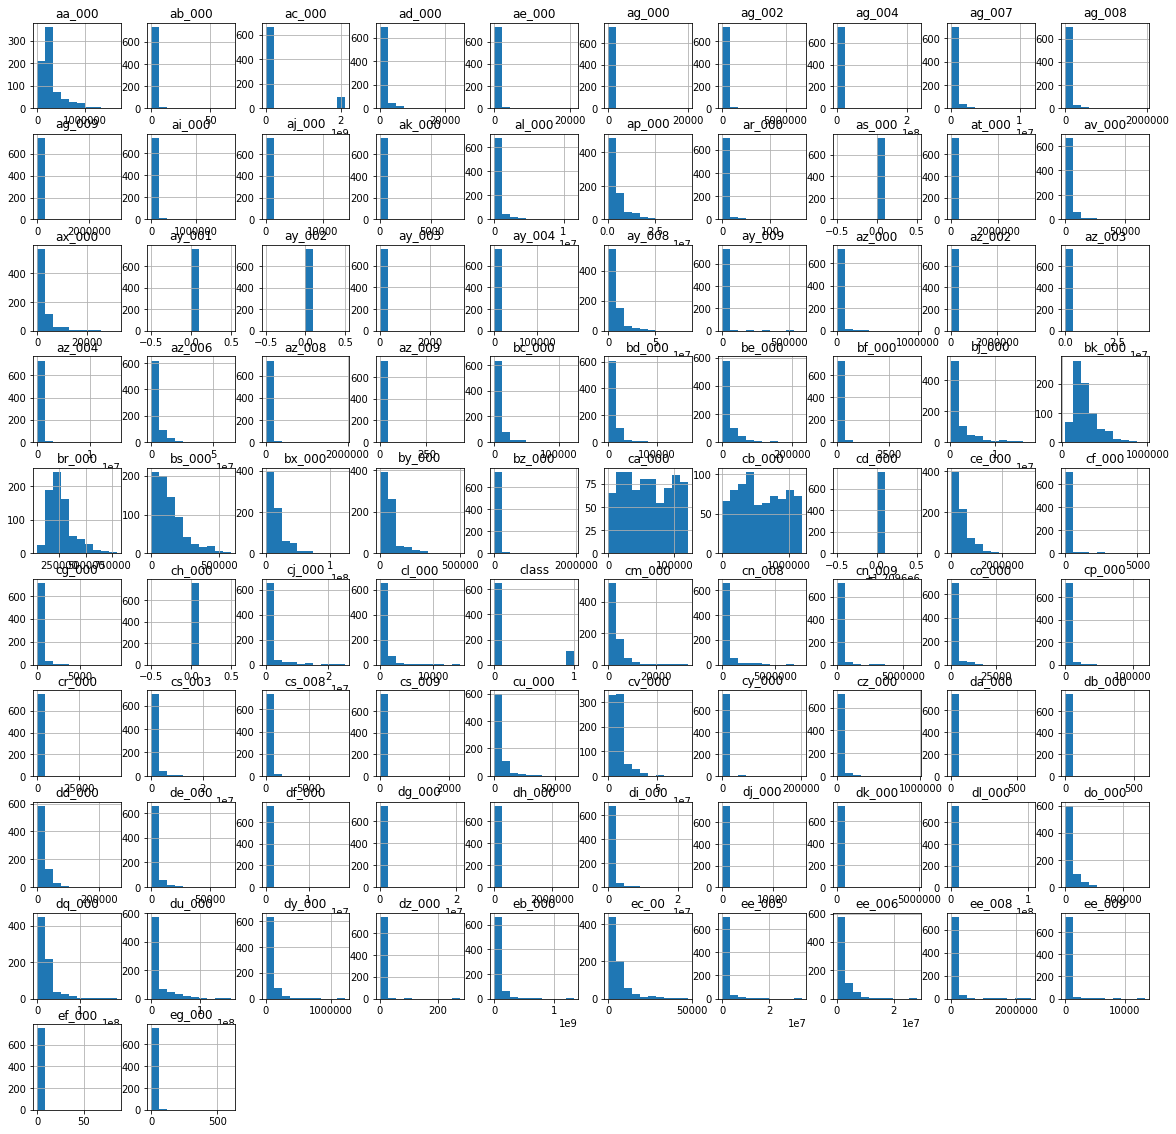

In [27]:
sdf_removed_hicorr.hist(figsize=(20, 20));

In [28]:
# Запустим тестирование со шкалированием StandartScaler()
result_1 = evaluate_data(test_df=sdf_removed_hicorr, report_df=result_1, target='class', test_label='Removed hicorr STD')

result_1.iloc[:,0:5].style.apply(highlight_max)

,Accuracy,Precision,Recall,F1,ROC-AUC
Baseline (log-reg),0.956000,0.812000,0.867000,0.839000,0.918000
Baseline (knn),0.912000,0.438000,0.875000,0.583000,0.895000
Removed hicorr STD (log-reg),0.969000,0.812000,0.963000,0.881000,0.966000
Removed hicorr STD (knn),0.916000,0.406000,1.000000,0.578000,0.956000


### 1.3. Определим и устраним дисбаланс классов целевой переменной

In [29]:
# Создадим новый DataFrame для тестирования
sdf_balanced = sdf_removed_hicorr.copy(deep=True)

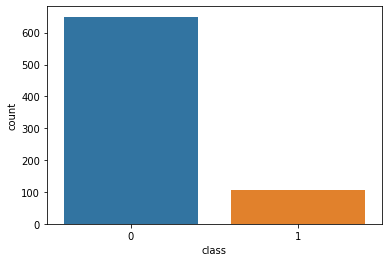

In [30]:
# Баланс целевой переменной
sns.countplot(x='class',data=sdf_balanced);

In [31]:
# Применим over-sampling целевой переменной с помощью SMOTE и запустим тестирование модели
result_1 = evaluate_data(test_df=sdf_balanced, report_df=result_1, target='class', 
                       scaler_type='std', ovs=True, test_label='Over_sample')

result_1.iloc[:,0:5].style.apply(highlight_max)

,Accuracy,Precision,Recall,F1,ROC-AUC
Baseline (log-reg),0.956000,0.812000,0.867000,0.839000,0.918000
Baseline (knn),0.912000,0.438000,0.875000,0.583000,0.895000
Removed hicorr STD (log-reg),0.969000,0.812000,0.963000,0.881000,0.966000
Removed hicorr STD (knn),0.916000,0.406000,1.000000,0.578000,0.956000
Over_sample (log-reg),0.947000,0.844000,0.794000,0.818000,0.884000
Over_sample (knn),0.894000,0.781000,0.595000,0.676000,0.779000


### 1.4. Применим log(x+1) к данным

In [32]:
# Создадим новый DataFrame для тестирования
sdf_log1p = sdf_removed_hicorr.copy(deep=True)

In [33]:
# Прологарифмируем значения
for col in sdf_log1p.columns:
    if col == 'class': continue
    sdf_log1p[col] = np.log1p(sdf_log1p[col])

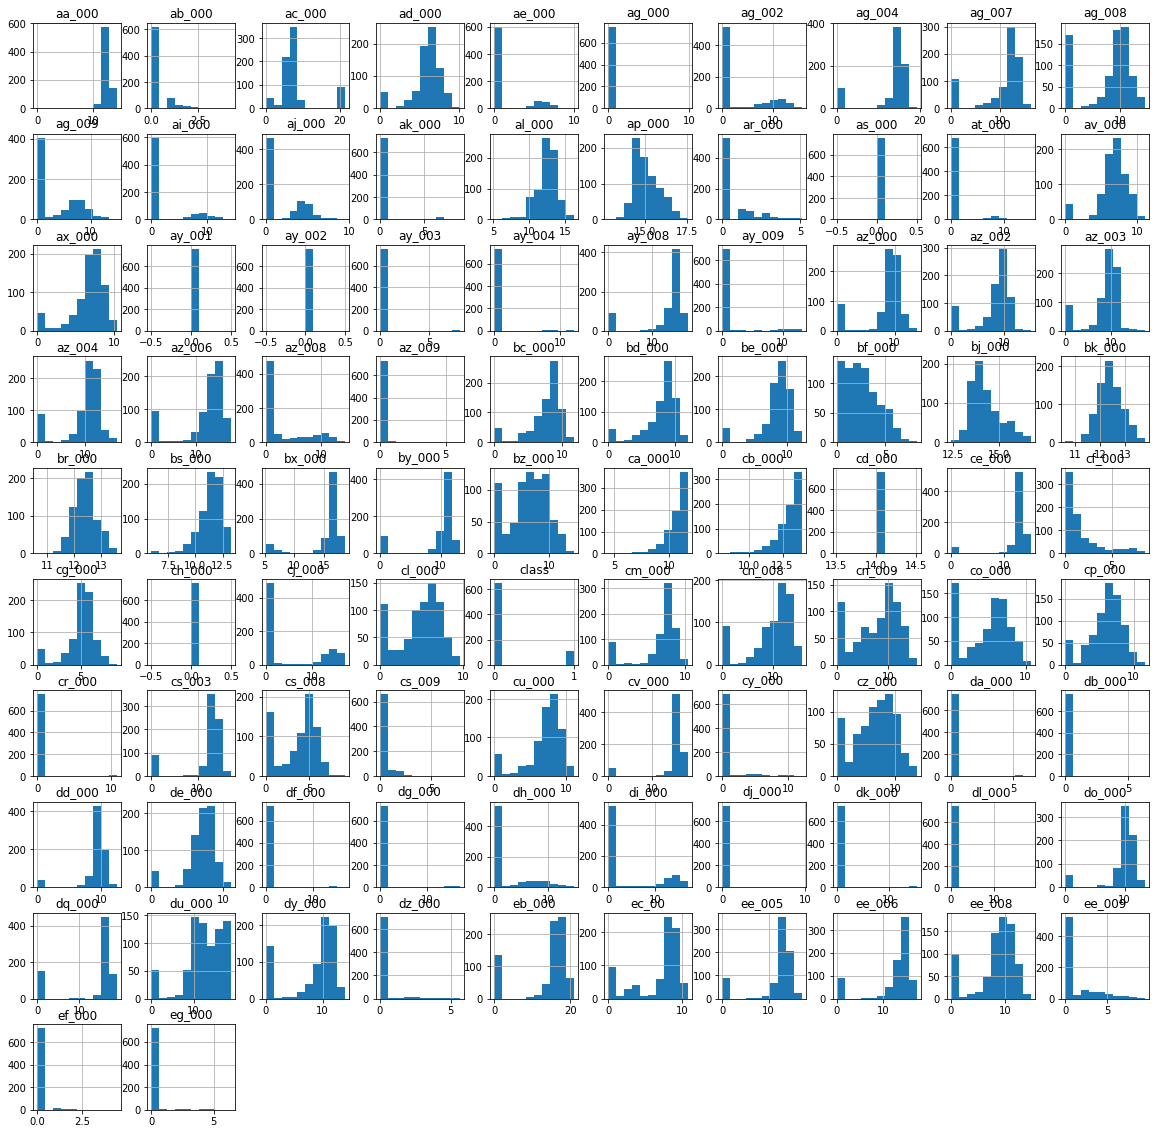

In [34]:
sdf_log1p.hist(figsize=(20, 20));

In [35]:
# Запустим тестирование модели
result_1 = evaluate_data(test_df=sdf_log1p, report_df=result_1, target='class', 
                       scaler_type='std', test_label='log1p')

result_1.iloc[:,0:5].style.apply(highlight_max)

,Accuracy,Precision,Recall,F1,ROC-AUC
Baseline (log-reg),0.956000,0.812000,0.867000,0.839000,0.918000
Baseline (knn),0.912000,0.438000,0.875000,0.583000,0.895000
Removed hicorr STD (log-reg),0.969000,0.812000,0.963000,0.881000,0.966000
Removed hicorr STD (knn),0.916000,0.406000,1.000000,0.578000,0.956000
Over_sample (log-reg),0.947000,0.844000,0.794000,0.818000,0.884000
Over_sample (knn),0.894000,0.781000,0.595000,0.676000,0.779000
log1p (log-reg),0.930000,0.719000,0.767000,0.742000,0.860000
log1p (knn),0.921000,0.531000,0.850000,0.654000,0.889000


### 1.5. Вывод

После удаления NaN получился весьма скромный датасет. Улучшить качество модели помогло лишь удаление сильноскоррелированных признаков (что хорошо отразилось при использовании log-reg), остальные действия не принесли какого-либо значимого улучшения

<a id="5"></a>
## Route #2 [(Наверх)](#0) 

Проведём замену NaN и проверим как это отразится на качестве модели

### 2.1. Baseline 

In [36]:
# Удалим признаки, где NaN > 70%
prct_missing = (scania_df.isna().sum()/scania_df.shape[0]*100).round(2)
sdf_replaced_nan = scania_df.drop(prct_missing[prct_missing > 70].index, axis=1, inplace=False)

# Разобъем датасет в разрезе целевой переменной
mask = sdf_replaced_nan['class'] > 0
sdf_true, sdf_false = sdf_replaced_nan[mask], sdf_replaced_nan[~mask]

# Заменим NaN на mode[0] во всех признаках, кроме целевой переменной
for i_df in [sdf_true, sdf_false]:
    for col in i_df.columns[1:]:
        i_df[col] = i_df[col].fillna(i_df[col].mode()[0])
    
# Склеим датасеты в один
sdf_replaced_nan = pd.concat([sdf_true, sdf_false])

In [37]:
sdf_replaced_nan.shape

(76000, 164)

In [38]:
# Запустим тестирование с базовыми настройками
result_2 = evaluate_data(test_df=sdf_replaced_nan, target='class', test_label='Baseline')
result_2.iloc[:,0:5].style.apply(highlight_max)

,Accuracy,Precision,Recall,F1,ROC-AUC
Baseline (log-reg),0.991000,0.667000,0.799000,0.728000,0.897000
Baseline (knn),0.990000,0.553000,0.814000,0.659000,0.903000


### 2.2. Определим и удалим сильноскоррелированные признаки

In [39]:
# Создадим новый DataFrame для тестирования
sdf_removed_hicorr = sdf_replaced_nan.copy(deep=True)

In [40]:
# Рассчитаем корреляции между признаками
corr = sdf_removed_hicorr.corr()

# Удалим из датасета сильноскоррелированные признаки (>= 0.8)
sdf_removed_hicorr.drop(columns=highly_correlated(corr, 0.8), axis=1, inplace=True)

In [41]:
sdf_removed_hicorr.shape

(76000, 111)

In [42]:
# Запустим тестирование со шкалированием StandartScaler()
result_2 = evaluate_data(test_df=sdf_removed_hicorr, report_df=result_2, target='class', test_label='Removed hicorr STD')

result_2.iloc[:,0:5].style.apply(highlight_max)

,Accuracy,Precision,Recall,F1,ROC-AUC
Baseline (log-reg),0.991000,0.667000,0.799000,0.728000,0.897000
Baseline (knn),0.990000,0.553000,0.814000,0.659000,0.903000
Removed hicorr STD (log-reg),0.991000,0.653000,0.801000,0.719000,0.897000
Removed hicorr STD (knn),0.989000,0.561000,0.797000,0.658000,0.894000


### 2.3. Определим и устраним дисбаланс классов целевой переменной

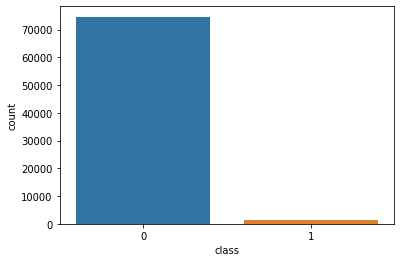

In [43]:
# Баланс целевой переменной
sns.countplot(x='class',data=sdf_removed_hicorr);

In [44]:
# Обрежем наш датасет равнопропорционально значениям целевой переменной
sdf_balanced = balanced_sample(sdf_removed_hicorr, 'class', count=2000)

In [45]:
sdf_balanced.shape

(2750, 111)

In [46]:
# Запустим тестирование модели
result_2 = evaluate_data(test_df=sdf_balanced, report_df=result_2, target='class', 
                       scaler_type='std', test_label='Balanced')

result_2.iloc[:,0:5].style.apply(highlight_max)

,Accuracy,Precision,Recall,F1,ROC-AUC
Baseline (log-reg),0.991000,0.667000,0.799000,0.728000,0.897000
Baseline (knn),0.990000,0.553000,0.814000,0.659000,0.903000
Removed hicorr STD (log-reg),0.991000,0.653000,0.801000,0.719000,0.897000
Removed hicorr STD (knn),0.989000,0.561000,0.797000,0.658000,0.894000
Balanced (log-reg),0.953000,0.932000,0.972000,0.952000,0.954000
Balanced (knn),0.941000,0.917000,0.962000,0.939000,0.942000


In [47]:
# Применим over-sampling целевой переменной с помощью SMOTE и запустим тестирование модели
result_2 = evaluate_data(test_df=sdf_removed_hicorr, report_df=result_2, target='class', 
                       scaler_type='std', ovs=True, test_label='Over_sample')

result_2.iloc[:,0:5].style.apply(highlight_max)

,Accuracy,Precision,Recall,F1,ROC-AUC
Baseline (log-reg),0.991000,0.667000,0.799000,0.728000,0.897000
Baseline (knn),0.990000,0.553000,0.814000,0.659000,0.903000
Removed hicorr STD (log-reg),0.991000,0.653000,0.801000,0.719000,0.897000
Removed hicorr STD (knn),0.989000,0.561000,0.797000,0.658000,0.894000
Balanced (log-reg),0.953000,0.932000,0.972000,0.952000,0.954000
Balanced (knn),0.941000,0.917000,0.962000,0.939000,0.942000
Over_sample (log-reg),0.971000,0.900000,0.371000,0.525000,0.685000
Over_sample (knn),0.978000,0.876000,0.443000,0.589000,0.721000


### 2.4. Определим 10 популярных features и сократим модель

In [57]:
imp_feats = important_features(sdf_balanced, 'class', np.arange(0.01,0.1,0.001), 10)

In [58]:
# Создадим новый DataFrame для тестирования
sdf_shrunk = sdf_balanced[['class']+imp_feats].copy(deep=True)

In [59]:
sdf_shrunk.shape

(2750, 10)

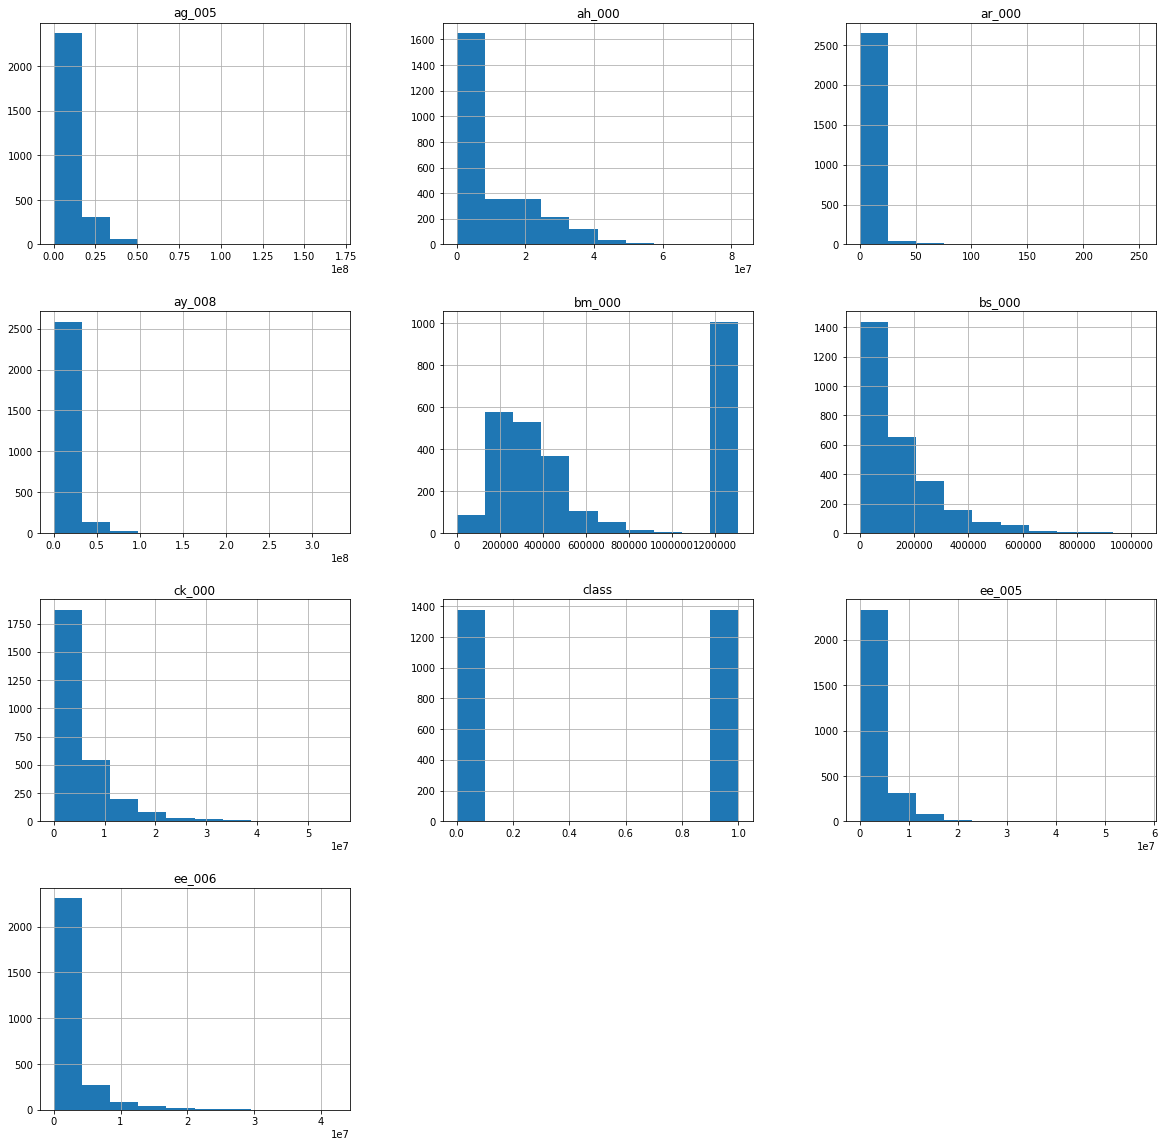

In [60]:
# Гистограммы переменных
sdf_shrunk.hist(figsize=(20, 20));

In [61]:
# Запустим тестирование модели
result_2 = evaluate_data(test_df=sdf_shrunk, report_df=result_2, target='class', 
                       scaler_type='std', test_label='Shrunk feats')

result_2.iloc[:,0:5].style.apply(highlight_max)

,Accuracy,Precision,Recall,F1,ROC-AUC
Baseline (log-reg),0.991000,0.667000,0.799000,0.728000,0.897000
Baseline (knn),0.990000,0.553000,0.814000,0.659000,0.903000
Removed hicorr STD (log-reg),0.991000,0.653000,0.801000,0.719000,0.897000
Removed hicorr STD (knn),0.989000,0.561000,0.797000,0.658000,0.894000
Balanced (log-reg),0.953000,0.932000,0.972000,0.952000,0.954000
Balanced (knn),0.941000,0.917000,0.962000,0.939000,0.942000
Over_sample (log-reg),0.971000,0.900000,0.371000,0.525000,0.685000
Over_sample (knn),0.978000,0.876000,0.443000,0.589000,0.721000
Shrunk feats (log-reg),0.941000,0.930000,0.950000,0.940000,0.941000
Shrunk feats (knn),0.941000,0.947000,0.935000,0.941000,0.941000


### 2.5. Применим log(x+1) к данным

In [62]:
# Создадим новый DataFrame для тестирования
sdf_log1p = sdf_shrunk.copy(deep=True)

In [63]:
# Прологарифмируем значения некоторых переменных
for col in ['ag_005', 'ah_000', 'ar_000', 'ay_008', 'ee_005', 'ee_006']:
    sdf_log1p[col] = np.log1p(sdf_log1p[col])

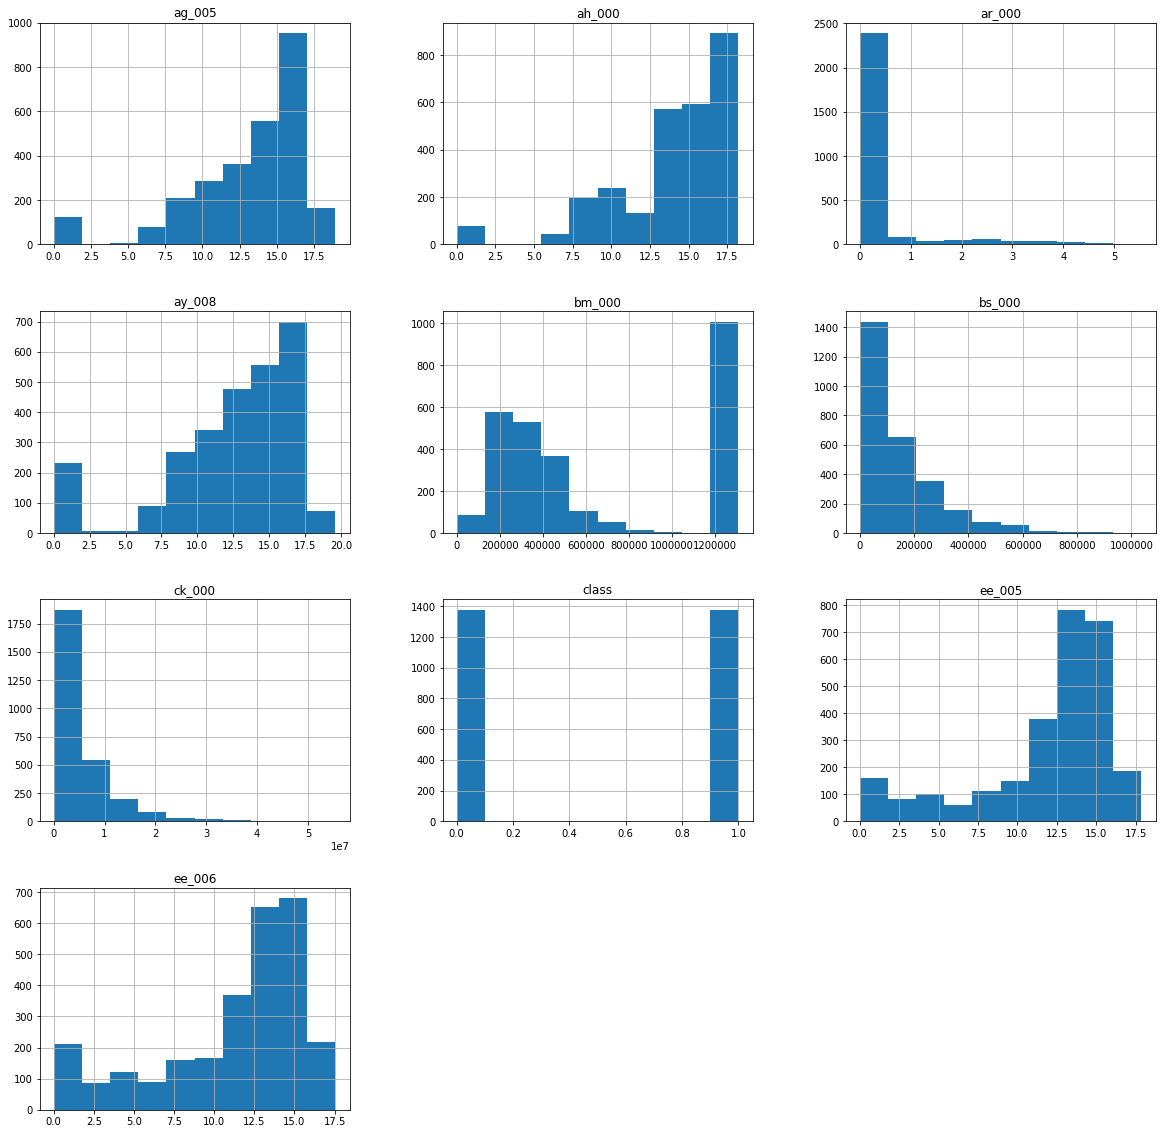

In [64]:
sdf_log1p.hist(figsize=(20, 20));

In [65]:
# Запустим тестирование модели
result_2 = evaluate_data(test_df=sdf_log1p, report_df=result_2, target='class', 
                       scaler_type='std', test_label='log1p')

result_2.iloc[:,0:5].style.apply(highlight_max)

,Accuracy,Precision,Recall,F1,ROC-AUC
Baseline (log-reg),0.991000,0.667000,0.799000,0.728000,0.897000
Baseline (knn),0.990000,0.553000,0.814000,0.659000,0.903000
Removed hicorr STD (log-reg),0.991000,0.653000,0.801000,0.719000,0.897000
Removed hicorr STD (knn),0.989000,0.561000,0.797000,0.658000,0.894000
Balanced (log-reg),0.953000,0.932000,0.972000,0.952000,0.954000
Balanced (knn),0.941000,0.917000,0.962000,0.939000,0.942000
Over_sample (log-reg),0.971000,0.900000,0.371000,0.525000,0.685000
Over_sample (knn),0.978000,0.876000,0.443000,0.589000,0.721000
Shrunk feats (log-reg),0.941000,0.930000,0.950000,0.940000,0.941000
Shrunk feats (knn),0.941000,0.947000,0.935000,0.941000,0.941000


### 2.5. Вывод

Улучшить качество модели помогло удаление сильноскоррелированных признаков (что хорошо отразилось при использовании log-reg), а так же создание сбалансированного датасета. Баланс классов с помощью SMOTE улучшил accuracy в сравнении с простой обрезкой, но сильно упал recall и f1. Выделение best features с помощью регуляризации, а также применение метода log(x+1) не принесло ожидаемого эффекта (хотя recall в последнем и увеличился)

<a id="6"></a>
## Итоговое заключение [(Наверх)](#0) 

Сравним результаты тестирования

### Route #1

In [66]:
result_1.iloc[:,0:5].style.apply(highlight_max)

,Accuracy,Precision,Recall,F1,ROC-AUC
Baseline (log-reg),0.956000,0.812000,0.867000,0.839000,0.918000
Baseline (knn),0.912000,0.438000,0.875000,0.583000,0.895000
Removed hicorr STD (log-reg),0.969000,0.812000,0.963000,0.881000,0.966000
Removed hicorr STD (knn),0.916000,0.406000,1.000000,0.578000,0.956000
Over_sample (log-reg),0.947000,0.844000,0.794000,0.818000,0.884000
Over_sample (knn),0.894000,0.781000,0.595000,0.676000,0.779000
log1p (log-reg),0.930000,0.719000,0.767000,0.742000,0.860000
log1p (knn),0.921000,0.531000,0.850000,0.654000,0.889000


### Route #2

In [67]:
result_2.iloc[:,0:5].style.apply(highlight_max)

,Accuracy,Precision,Recall,F1,ROC-AUC
Baseline (log-reg),0.991000,0.667000,0.799000,0.728000,0.897000
Baseline (knn),0.990000,0.553000,0.814000,0.659000,0.903000
Removed hicorr STD (log-reg),0.991000,0.653000,0.801000,0.719000,0.897000
Removed hicorr STD (knn),0.989000,0.561000,0.797000,0.658000,0.894000
Balanced (log-reg),0.953000,0.932000,0.972000,0.952000,0.954000
Balanced (knn),0.941000,0.917000,0.962000,0.939000,0.942000
Over_sample (log-reg),0.971000,0.900000,0.371000,0.525000,0.685000
Over_sample (knn),0.978000,0.876000,0.443000,0.589000,0.721000
Shrunk feats (log-reg),0.941000,0.930000,0.950000,0.940000,0.941000
Shrunk feats (knn),0.941000,0.947000,0.935000,0.941000,0.941000


### По совокупкности оценочных параметров оба маршрута тестирования показали свою целесообразность к улучшению первоначальных показателей, но считаю второй маршрут тестирования более подходящим для данного набора данных.